
# Malaria Cell Images Classification 


Nithya Mylakumar  
Sai Divya Teja Konda  
Yasasree Singam  

## Importing The Modules

In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from tensorflow.keras.applications import resnet50
from keras.models import *
from keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3, preprocess_input
warnings.filterwarnings('ignore')


In [36]:
from PIL import Image
import seaborn as sns

## Data Preparation

In [3]:
def data_prep(parasitized,uninfected):

    parasitized= ["cell_images/Parasitized" + '/' +  parasitize for parasitize in parasitized]
    uninfected= ["cell_images/Uninfected" + '/' +  uninfect for uninfect in uninfected]

    labels = len(parasitized)*['parasitized'] + len(uninfected)*['uninfected']
    data = parasitized + uninfected

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})


df = data_prep(os.listdir('cell_images/Parasitized/'), os.listdir('cell_images/Uninfected/'))
df.head()

,Image_Path,Labels
0,cell_images/Parasitized/C100P61ThinF_IMG_20150...,parasitized
1,cell_images/Parasitized/C100P61ThinF_IMG_20150...,parasitized
2,cell_images/Parasitized/C100P61ThinF_IMG_20150...,parasitized
3,cell_images/Parasitized/C100P61ThinF_IMG_20150...,parasitized
4,cell_images/Parasitized/C100P61ThinF_IMG_20150...,parasitized


In [8]:
df.shape

(27560, 2)

## Displaying 5 Images For Each Of The Two Labels

Displaying 5 Parasitized Images: 



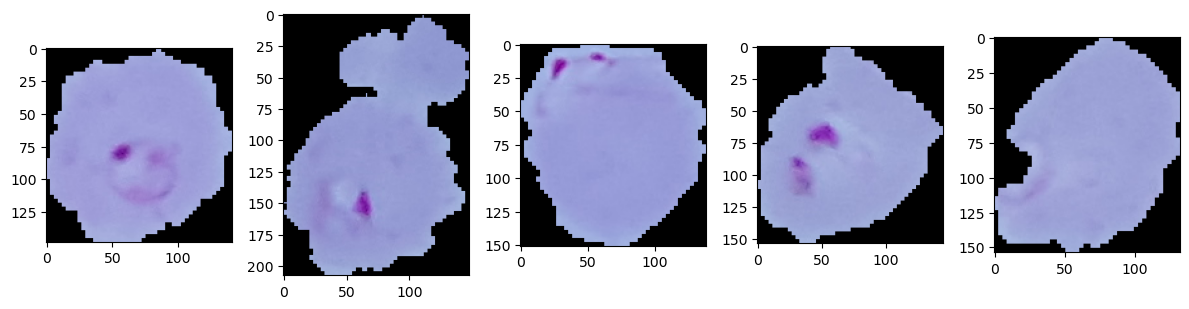


Displaying 5 Uninfected Images: 



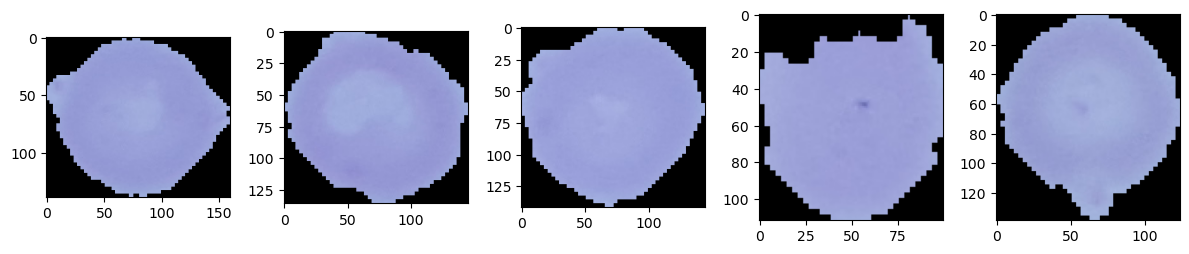

In [17]:
print("Displaying 5 Parasitized Images: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'parasitized']['Image_Path'][i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()


print()
print("Displaying 5 Uninfected Images: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'uninfected']['Image_Path'].reset_index(drop=True)[i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()


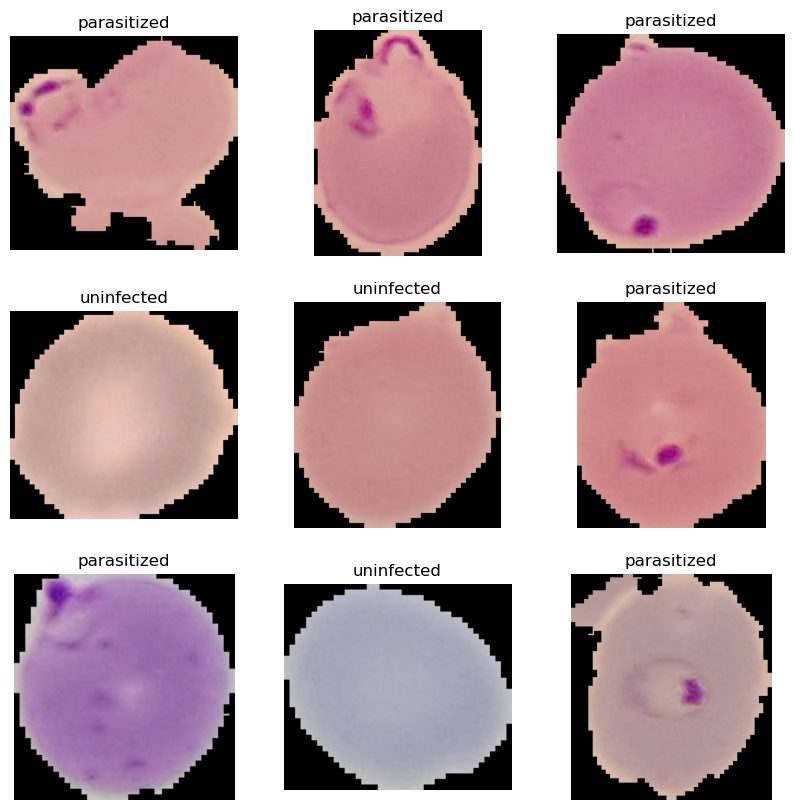

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i, (idx, row) in enumerate(df.sample(9).iterrows()):
    img = Image.open(row['Image_Path'])
    axes[i//3, i%3].imshow(img)
    axes[i//3, i%3].axis('off')
    axes[i//3, i%3].set_title(row['Labels'])
plt.show()

## Distribution Of Samples

Text(0.5, 1.0, 'Distribution of samples according to the categories')

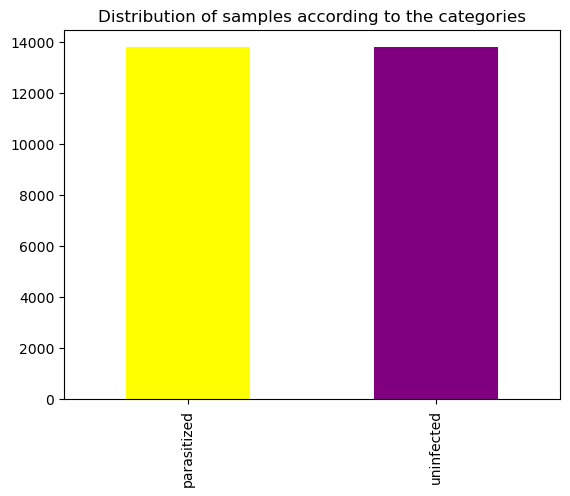

In [30]:
df['Labels'].value_counts().plot(kind = 'bar', color = ['yellow', 'purple'])
plt.title('Distribution of samples according to the categories')

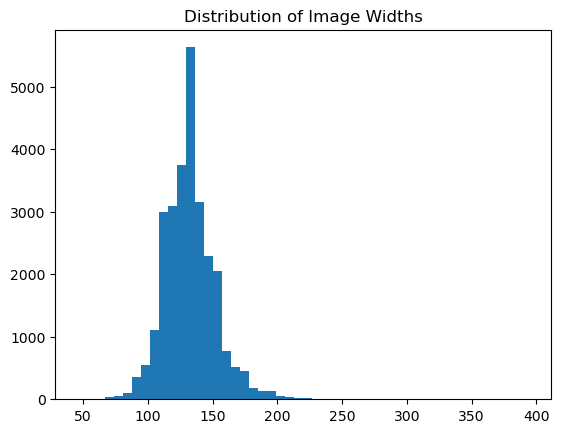

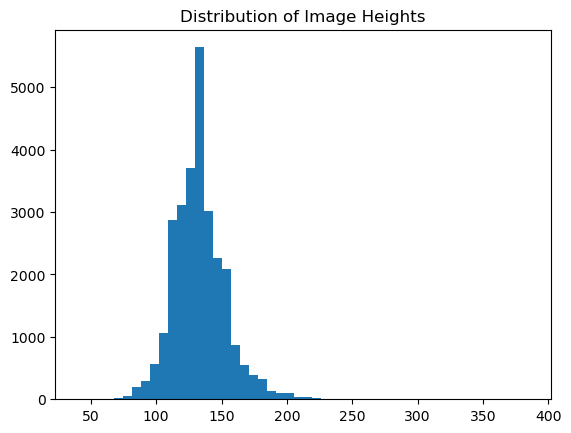

In [37]:
# Filter out 'Thumbs.db' file
df = df[df['Image_Path'].apply(lambda x: 'Thumbs.db' not in x)]

# Get image file names
df['Image_File'] = df['Image_Path'].apply(lambda x: os.path.basename(x))

# Get image sizes
image_sizes = df['Image_Path'].apply(lambda x: Image.open(x).size)
width, height = zip(*image_sizes)

# Plot distribution of image widths
plt.hist(width, bins=50)
plt.title('Distribution of Image Widths')
plt.show()

# Plot distribution of image heights
plt.hist(height, bins=50)
plt.title('Distribution of Image Heights')
plt.show()

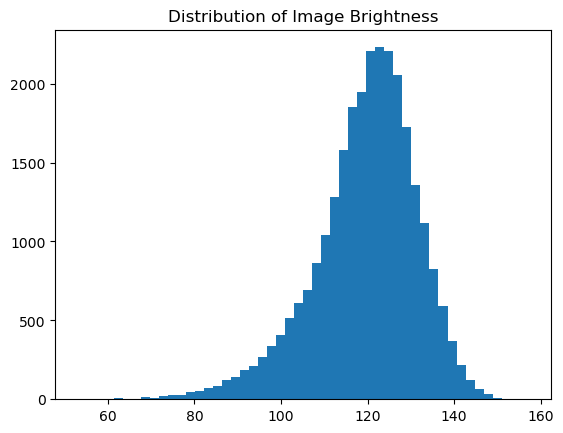

In [39]:
brightness = []
for index, row in df.iterrows():
    img = Image.open(row['Image_Path'])
    img = np.array(img)
    brightness.append(np.mean(img))

plt.hist(brightness, bins=50)
plt.title('Distribution of Image Brightness')
plt.show()

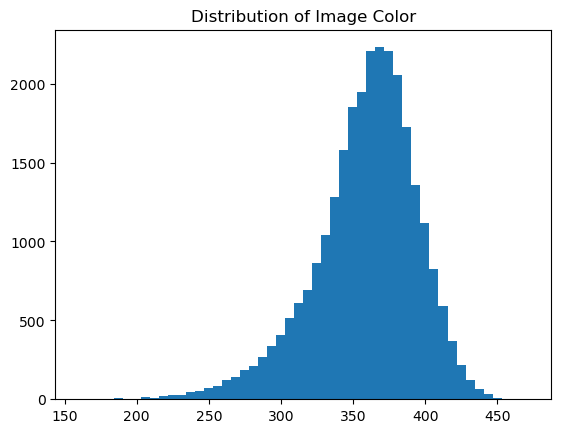

In [40]:
color = []
for index, row in df.iterrows():
    img = Image.open(row['Image_Path'])
    img = np.array(img)
    color.append(np.mean(img[:,:,0])+np.mean(img[:,:,1])+np.mean(img[:,:,2]))

plt.hist(color, bins=50)
plt.title('Distribution of Image Color')
plt.show()

✅

The dataset has 2 folders which consists of parasitized and uninfected data images

The images are in png format and the naming convension is C33P1thinF_IMG_20150619_114756a_cell_179.png

For the images that are in parasitized we added a path which is taken from so that it can be classified as parasitized or uninfected.

we then combined both the folders into one and created a dataframe consisting of 2 columns as image_path and labels

In [24]:
from matplotlib.image import imread
import seaborn as sns

In [22]:
dim1 = []
dim2 = []

for image_filename in df['Image_Path']:
    if image_filename[-3:] == 'png': # to eliminate encountering Thumbs.db (Thumbs.db is nothing but the image cache file)
        img = imread(image_filename)
        d1,d2,colors = img.shape #(image.shape is in the form (130, 130, 3))
        dim1.append(d1)
        dim2.append(d2)

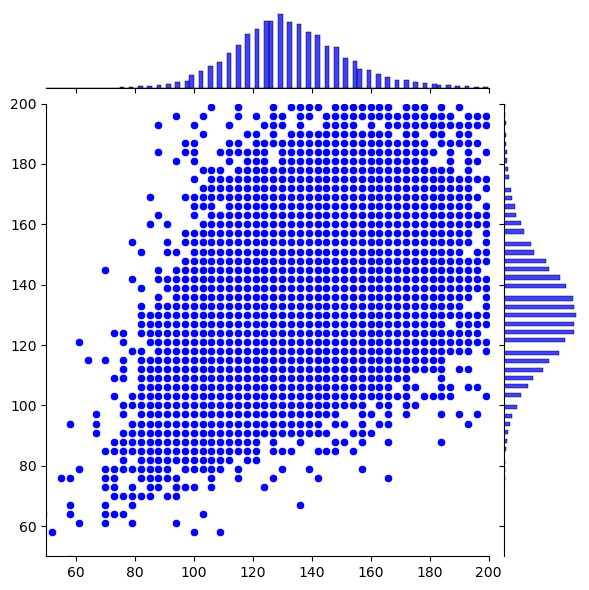

In [29]:
sns.jointplot(x=dim1, y=dim2, color='blue', xlim=(50, 200), ylim=(50, 200))

## Augmenting The Data

In [19]:
train, test = train_test_split(df, test_size = .20)

img_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest', validation_split=0.2)
                               
                               
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

✅

Data augmentation is a technique used to artificially increase the size of our training set by generating new samples from the existing ones. It can help reduce overfitting and improve the generalization ability of the model by exposing it to a wider range of variations in the data. In the code you provided, img_datagen is an instance of the ImageDataGenerator class, which will apply a set of image augmentations to the training data during the training process. These augmentations, such as rotation, shifting, shearing, zooming, and flipping, can help the model learn features that are more robust to variations in the input data.

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2), tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'), tf.keras.callbacks.TensorBoard(log_dir='./logs')]: This line creates a list of callbacks to use during training. Callbacks are functions that are called during training at certain points (e.g., after each epoch) to perform specific tasks (e.g., early stopping, saving the best model, logging metrics). In this case, three callbacks are used:

EarlyStopping: This callback monitors a validation metric (specified by the monitor argument, which defaults to 'val_loss') and stops training early if the metric does not improve for a certain number of epochs (specified by the patience argument).

ModelCheckpoint: This callback saves the model after each epoch if the validation loss improves. The filepath argument specifies the format for the saved model filenames (in this case, the filenames will include the epoch number and the validation loss).

TensorBoard: This callback logs training and validation metrics to a TensorBoard directory (specified by the log_dir argument), which can be visualized using the TensorBoard web application.

In [20]:
def plot_loss_and_accuracy(mo_fit):
    accuracy = mo_fit.history['accuracy']
    loss = mo_fit.history['loss']
    validation_loss = mo_fit.history['val_loss']
    validation_accuracy = mo_fit.history['val_accuracy']


    plt.figure(figsize=(15, 7))
    plt.subplot(2, 2, 1)
    plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
    plt.plot(range(len(accuracy)), validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Accuracy : Training Vs Validation ')

    
    plt.subplot(2, 2, 2)
    plt.plot(range(len(accuracy)), loss, label='Training Loss')
    plt.plot(range(len(accuracy)), validation_loss, label='Validation Loss')
    plt.title('Loss : Training Vs Validation ')
    plt.legend(loc='upper right')
    plt.show()


## Building CNN

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 82s 788ms/step - loss: 4.1236 - accuracy: 0.5390 - val_loss: 0.7213 - val_accuracy: 0.5390
Epoch 2/4
100/100 [==============================] - 53s 531ms/step - loss: 0.7037 - accuracy: 0.5320 - val_loss: 0.6847 - val_accuracy: 0.5570
Epoch 3/4
100/100 [==============================] - 51s 515ms/step - loss: 0.6820 - accuracy: 0.5500 - val_loss: 0.6728 - val_accuracy: 0.5450
Epoch 4/4
100/100 [==============================] - 50s 498ms/step - loss: 0.6973 - accuracy: 0.5590 - val_loss: 0.6584 - val_accuracy: 0.6540


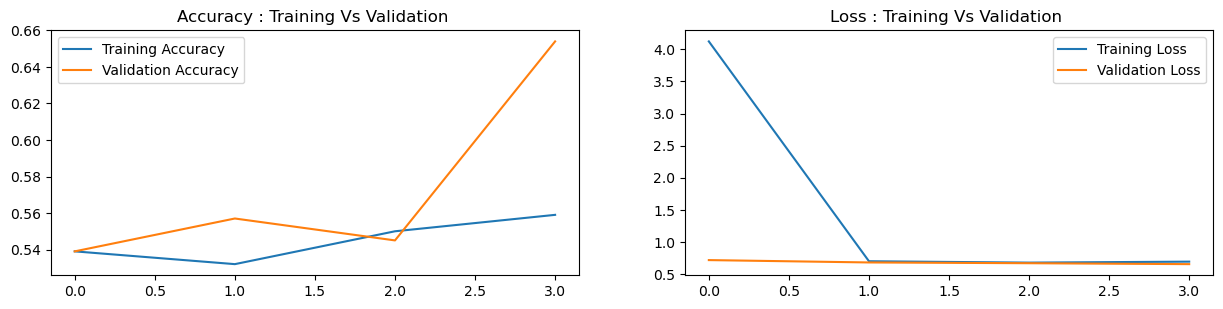

In [9]:
def cnn_model(df, train, test, my_callbacks):
    
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  
                                               class_mode='binary',target_size=(134,134), shuffle=False, 
                                               batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',
                                             class_mode='binary',  target_size=(134,134), shuffle=False, 
                                             batch_size=10, seed=10, subset='validation')
    
    model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(1, activation='sigmoid')
  ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    model_history = model.fit_generator(generator = x_train, 
                   steps_per_epoch = 100,
                   epochs = 4 ,
                   validation_data = x_test,
                   validation_steps = 100, callbacks=my_callbacks)
    
    return model_history

    
plot_loss_and_accuracy(cnn_model(df, train, test, my_callbacks))


## Resnet Model

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 142s 1s/step - loss: 0.5981 - accuracy: 0.7990 - val_loss: 0.6516 - val_accuracy: 0.8760
Epoch 2/4
100/100 [==============================] - 107s 1s/step - loss: 0.4737 - accuracy: 0.8540 - val_loss: 0.6047 - val_accuracy: 0.9110
Epoch 3/4
100/100 [==============================] - 105s 1s/step - loss: 0.3728 - accuracy: 0.8740 - val_loss: 0.7440 - val_accuracy: 0.9230
Epoch 4/4
100/100 [==============================] - 106s 1s/step - loss: 0.3088 - accuracy: 0.9080 - val_loss: 5.0193 - val_accuracy: 0.7760


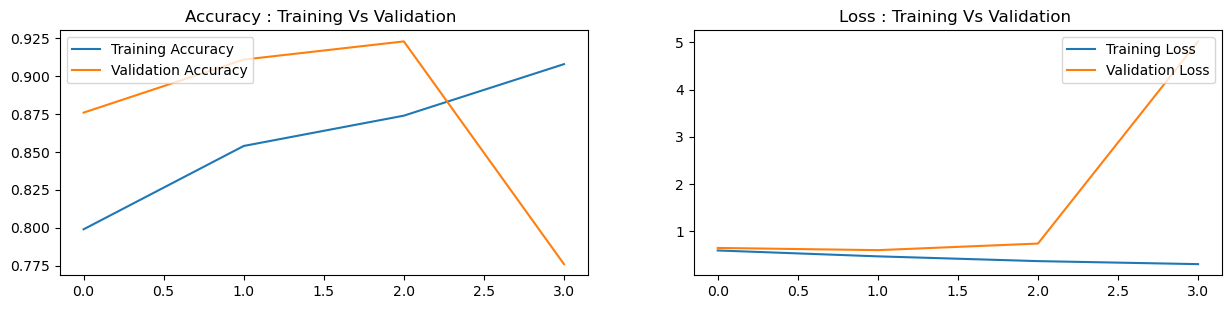

In [10]:
def resnet_model(df, train, test, my_callbacks):
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(64,64), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(64,64), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    resnet_model=resnet50.ResNet50(weights='imagenet',include_top=False,input_shape=(64,64,3))
    model=Sequential()
    model.add(resnet_model)
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    
    
    model_history = model.fit(
    x_train,
    steps_per_epoch=100,
    validation_data=x_test,
    validation_steps=100,
    epochs = 4, callbacks=my_callbacks)
    
    
    return model_history
    
plot_loss_and_accuracy(resnet_model(df, train, test, my_callbacks))

## Building VGG 19

Found 17639 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 948s 9s/step - loss: 1.1974 - accuracy: 0.5070 - val_loss: 0.7206 - val_accuracy: 0.4700
Epoch 2/4
100/100 [==============================] - 939s 9s/step - loss: 0.5254 - accuracy: 0.7540 - val_loss: 0.2252 - val_accuracy: 0.9230
Epoch 3/4
100/100 [==============================] - 937s 9s/step - loss: 0.3238 - accuracy: 0.9110 - val_loss: 0.2023 - val_accuracy: 0.9270
Epoch 4/4
100/100 [==============================] - 951s 10s/step - loss: 0.2306 - accuracy: 0.9260 - val_loss: 0.3138 - val_accuracy: 0.9560


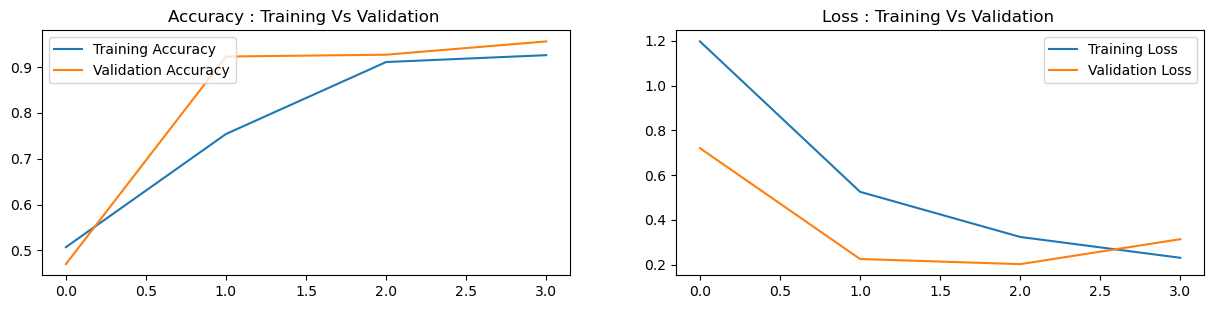

In [21]:
def vgg19_model(df, train, test, my_callbacks):

    learning_rate = [1e-4, 1e-2,1]
    for i in learning_rate:
        x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='training')
        x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='validation')
    
        vgg19_model = VGG19(input_shape=(224,224,3), weights='imagenet',include_top=False)
        model=Sequential()
        model.add(vgg19_model)
        model.add(Flatten())
        model.add(Dense(1024,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=keras.optimizers.RMSprop(lr=i),loss='binary_crossentropy',metrics=['accuracy'])
    
        model_history = model.fit(
        x_train,
        steps_per_epoch=100,
        validation_data=x_test,
        validation_steps=100, 
        epochs = 4 , callbacks=my_callbacks)
    
    return model_history
    
plot_loss_and_accuracy(vgg19_model(df, train, test, my_callbacks))